In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import assim_tools
import config as c

In [3]:
from assim_tools.state import read_field, read_state_info

In [2]:
##name of the state variable bin file
binfile = '/cluster/work/users/yingyue/exp1/analysis/202310230000/post_state.bin'

In [4]:
info = assim_tools.parse_state_info(c)

In [4]:
info

{'nx': 1667,
 'ny': 1500,
 'size': 1050476800,
 'fields': {0: {'name': 'ocean_velocity',
   'source': 'topaz.v5',
   'dtype': 'float',
   'is_vector': True,
   'units': 'm/s',
   'err_type': 'normal',
   'time': datetime.datetime(2023, 10, 23, 0, 0),
   'dt': 6.0,
   'k': -1,
   'pos': 0},
  1: {'name': 'ocean_velocity',
   'source': 'topaz.v5',
   'dtype': 'float',
   'is_vector': True,
   'units': 'm/s',
   'err_type': 'normal',
   'time': datetime.datetime(2023, 10, 23, 0, 0),
   'dt': 6.0,
   'k': -2,
   'pos': 10504768},
  2: {'name': 'ocean_velocity',
   'source': 'topaz.v5',
   'dtype': 'float',
   'is_vector': True,
   'units': 'm/s',
   'err_type': 'normal',
   'time': datetime.datetime(2023, 10, 23, 0, 0),
   'dt': 6.0,
   'k': -3,
   'pos': 21009536},
  3: {'name': 'ocean_velocity',
   'source': 'topaz.v5',
   'dtype': 'float',
   'is_vector': True,
   'units': 'm/s',
   'err_type': 'normal',
   'time': datetime.datetime(2023, 10, 23, 0, 0),
   'dt': 6.0,
   'k': -4,
   'pos

In [5]:
fld_id = [i for i,r in info['fields'].items() if r['name']=='ocean_temp' and r['k']==-1][0]

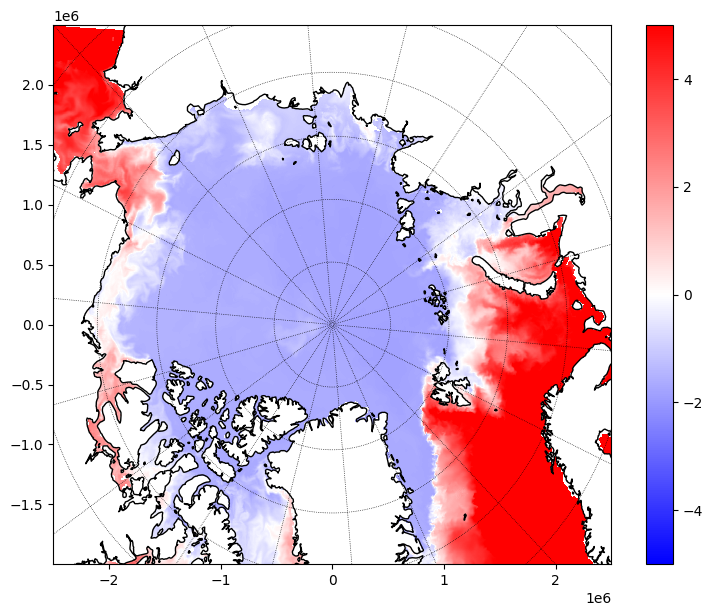

In [11]:
##check field from binfile
mem_id = 0

fld = read_field(binfile, info, c.mask, mem_id, fld_id)

fig, ax = plt.subplots(1, 1, figsize=(9,7))
im = c.grid.plot_field(ax, fld[...], vmin=-5, vmax=5, cmap='bwr')
plt.colorbar(im)
c.grid.plot_land(ax)

In [6]:
ii, jj = np.meshgrid(np.arange(c.nx), np.arange(c.ny))
inds = jj*c.nx + ii
inds = inds[~c.mask]


In [95]:
nobs = 2000

np.random.seed(1)
obs_ind = np.random.randint(inds.size*0.3, inds.size*0.8, nobs)
obs_x = c.grid.x[~c.mask][obs_ind]
obs_y = c.grid.y[~c.mask][obs_ind]

mem_id = 99
truth = assim_tools.read_field(binfile, info, c.mask, mem_id, fld_id)
obs_err = 0.1
obs = truth[~c.mask][obs_ind] + np.random.normal(0, obs_err, nobs)

In [51]:
state_prior = np.zeros((c.nens, c.ny, c.nx))
for mem_id in range(c.nens):
    fld = assim_tools.read_field(binfile, info, c.mask, mem_id, fld_id)
    state_prior[mem_id, ...] = fld
state_post = state_prior.copy()

In [96]:
##obs prior for ensemble
obs_prior = np.zeros((c.nens, nobs))

for mem_id in range(c.nens):
    fld = assim_tools.read_field(binfile, info, c.mask, mem_id, fld_id)
    obs_prior[mem_id, :] = fld[~c.mask][obs_ind]


In [97]:
obs_prior_mean = np.mean(obs_prior, axis=0)
obs_prior_std = np.std(obs_prior, axis=0)

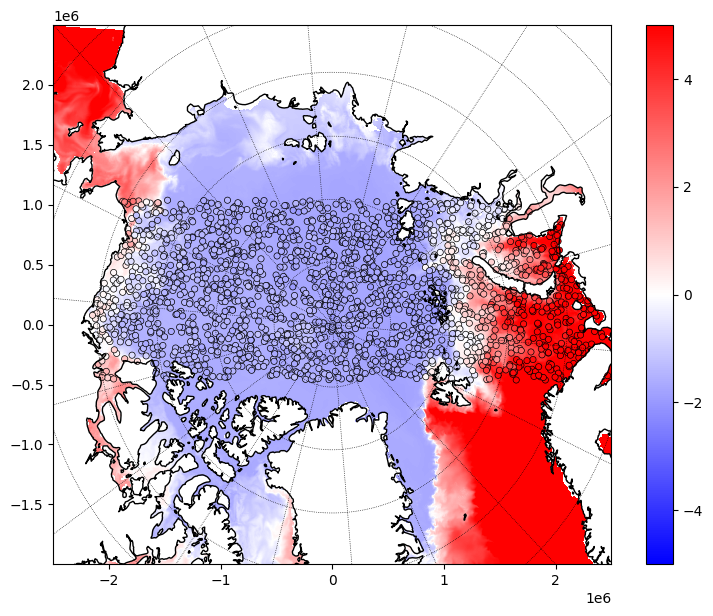

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(9,7))

im = c.grid.plot_field(ax, fld[...], vmin=-5, vmax=5, cmap='bwr')
plt.colorbar(im)

oc.grid.plot_land(ax)

vmin = -5
vmax = 5
cmap = [plt.cm.bwr(x) for x in np.linspace(0, 1, 40)]

cind = np.maximum(np.minimum(np.round((obs-vmin)/(vmax-vmin)*40), 40-1), 0).astype(int)
ax.scatter(obs_x, obs_y, s=20, color=np.array(cmap)[cind, 0:3], edgecolor='k', linewidth=0.5)


In [45]:
comm = assim_tools.parallel_start()
nproc = 256
comm.size = nproc

In [46]:
nx_tile = int(np.round(np.sqrt(c.nx * c.ny / nproc / 3)))
ny, nx = c.grid.x.shape
tile_list = [(i, np.minimum(i+nx_tile, nx), 1, j, np.minimum(j+nx_tile, ny), 1)
             for j in np.arange(0, ny, nx_tile) for i in np.arange(0, nx, nx_tile)]

In [100]:
obs_i = (obs_x - c.grid.xmin ) / c.grid.dx
obs_j = (obs_y - c.grid.ymin ) / c.grid.dx
#obs_tile_id = obs_j//nx_tile * np.ceil(nx/nx_tile) + obs_i//nx_tile


In [101]:
obs_list = {}
hroi = 30
obs_id = np.arange(nobs)
for tile_id, corners in enumerate(tile_list):
    istart,iend,di,jstart,jend,dj = corners
    cond1 = (np.hypot(np.minimum(np.abs(obs_i-istart), np.abs(obs_i-iend)),
                     np.minimum(np.abs(obs_j-jstart), np.abs(obs_j-jend))) < hroi)
    cond2 = np.logical_and(np.logical_and(obs_i>=istart, obs_i<=iend), np.logical_and(obs_j>jstart-hroi, obs_j<jend+hroi))
    cond3 = np.logical_and(np.logical_and(obs_j>=jstart, obs_j<=jend), np.logical_and(obs_i>istart-hroi, obs_i<iend+hroi))
    obs_list[tile_id] = obs_id[np.where(np.logical_or(cond1, np.logical_or(cond2, cond3)))]

In [102]:
nloc_tile = np.array([np.sum((~c.mask[j1:j2:dj, i1:i2:di]).astype(int)) for i1,i2,di,j1,j2,dj in tile_list])
nobs_tile = np.array([len(obs_list[i]) for i in range(len(tile_list))])
load_on_tile = np.maximum(nloc_tile, 1) * np.maximum(nobs_tile, 1)
tile_list_proc = assim_tools.distribute_tasks(comm, tile_list, load_on_tile)


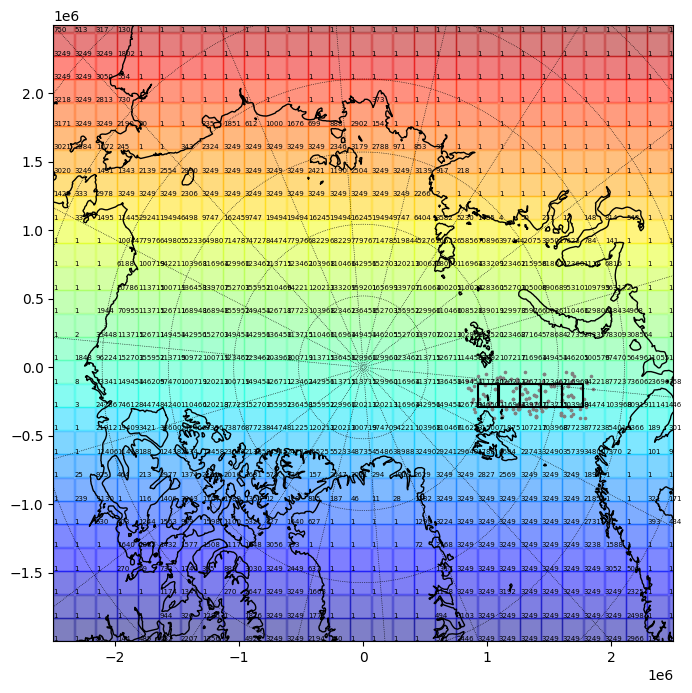

In [103]:
##show load on map
fig, ax = plt.subplots(1, 1, figsize=(8,8))

c.grid.plot_land(ax)

#cmap = [plt.cm.jet(x) for x in np.linspace(0, 1, nproc+1)]
#for proc_id in range(1):
#    for i1,i2,di,j1,j2,dj in tile_list_proc[proc_id]:
#        print(i1)
#        ii_tile, jj_tile = np.meshgrid(np.arange(i1,i2,di), np.arange(j1,j2,dj))
#        #ind = ~c.mask[j1:j2:dj, i1:i2:di]
#        ax.scatter(c.grid.x[j1:j2:dj, i1:i2:di], c.grid.y[j1:j2:dj, i1:i2:di], 3, color=cmap[proc_id])

cmap = [plt.cm.jet(x) for x in np.linspace(0, 1, len(tile_list)+1)]
x_ = c.grid.x[0, :]
y_ = c.grid.y[:, 0]
for t_id, t_list in enumerate(tile_list):
    i1,i2,di,j1,j2,dj = t_list
    ax.fill([x_[i1], x_[i1], x_[i2-1], x_[i2-1], x_[i1]], [y_[j1], y_[j2-1], y_[j2-1], y_[j1], y_[j1]], color=cmap[t_id], alpha=.5)
    ax.text(x_[i1], y_[j1], '{}'.format(load_on_tile[t_id]), fontsize=5)
for t_id in np.arange(320,325):
    i1,i2,di,j1,j2,dj = tile_list[t_id]
    ax.plot([x_[i1], x_[i1], x_[i2-1], x_[i2-1], x_[i1]], [y_[j1], y_[j2-1], y_[j2-1], y_[j1], y_[j1]], color='k')
    ind = obs_list[t_id]
    ax.scatter(obs_x[ind], obs_y[ind], 10, color='gray', marker='.')

In [114]:
@njit
def update(obs, obs_err, obs_prior, state_prior, loc_func):
    nens, nlobs = obs_prior.shape
    state_post = state_prior.copy()
    
    S = np.zeros((nlobs, nens))
    dy = np.zeros((nlobs))
    W = np.zeros((nens, nens))

    obs_prior_mean = np.zeros(nlobs)
    for m in range(nens):
        obs_prior_mean += obs_prior[m, :]
    obs_prior_mean /= nens

    for p in range(nlobs):
        S[p, :] = (obs_prior[:, p] - obs_prior_mean[p]) * loc_func[p] / obs_err / np.sqrt(nens-1)
        dy[p] = (obs[p] - obs_prior_mean[p]) * loc_func[p] / obs_err / np.sqrt(nens-1)
    
    V = np.eye(nens) + S.T @ S
    L,e,Rh = np.linalg.svd(V)
    G = L @ np.diag(e**-1) @ Rh @ S.T

    for m in range(nens):
        W[m, :] = np.sum(G[m,:] * dy)

    W += L @ np.diag(e**-0.5) @ Rh

    for m in range(nens):
        state_post[m] = np.sum(state_prior * W[:, m])
   
    return state_post


In [53]:
@njit
def local_factor(obs_x, obs_y, x, y, roi, local_type='GC'):
    ## dist: input distance, ndarray
    ## roi: radius of influence, distance beyond which loc=0
    ## returns the localization factor loc
    dist = np.atleast_1d(np.hypot(obs_x - x, obs_y - y))
    loc = np.zeros(dist.shape)
    if roi>0:
        if local_type == 'GC': ##Gaspari-Cohn localization function
            r = dist / (roi / 2)
            loc1 = (((-0.25*r + 0.5)*r + 0.625)*r - 5.0/3.0) * r**2 + 1
            ind1 = np.where(dist<roi/2)
            loc[ind1] = loc1[ind1]
            r[np.where(r==0)] = 1e-10
            loc2 = ((((r/12.0 - 0.5)*r + 0.625)*r + 5.0/3.0)*r - 5.0)*r + 4 - 2.0/(3.0*r)
            ind2 = np.where(np.logical_and(dist>=roi/2, dist<roi))
            loc[ind2] = loc2[ind2]
        elif local_type == 'Boxcar':  #boxcar function from 1 to 0
            ind1 = np.where(dist<=roi)
            loc[ind1] = 1.0
            ind2 = np.where(dist>roi)
            loc[ind2] = 0.0
        else:
            raise ValueError('unknown localization function type: '+local_type)
    else:
        loc = np.ones(dist.shape)
    return loc

In [115]:
for tile_id in range(320, 325):
    istart,iend,di, jstart,jend,dj = tile_list[tile_id]
    obs_ind = obs_list[tile_id]

    for i in range(istart, iend, di):
        for j in range(jstart, jend, dj):
            nens = c.nens
            nlobs = len(obs_ind)
            if nlobs > 0:
                loc_func = local_factor(obs_x[obs_ind], obs_y[obs_ind], c.grid.x[j, i], c.grid.y[j, i], hroi*c.grid.dx, 'GC')
                ind = np.where(loc_func>0)
                state_post[:, j, i] = update(obs[obs_ind[ind]], obs_err, obs_prior[:, obs_ind[ind]], state_prior[:, j, i], loc_func[ind])


In [102]:
%timeit local_factor(obs_x[obs_ind], obs_y[obs_ind], c.grid.x[j, i], c.grid.y[j, i], hroi*c.grid.dx, 'GC')


10.9 µs ± 11 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [69]:
%timeit update(obs[obs_ind], obs_err, obs_prior[:, obs_ind], state_prior[:, j, i], loc_func)


535 µs ± 8.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


(-500000.0, 100000.0)

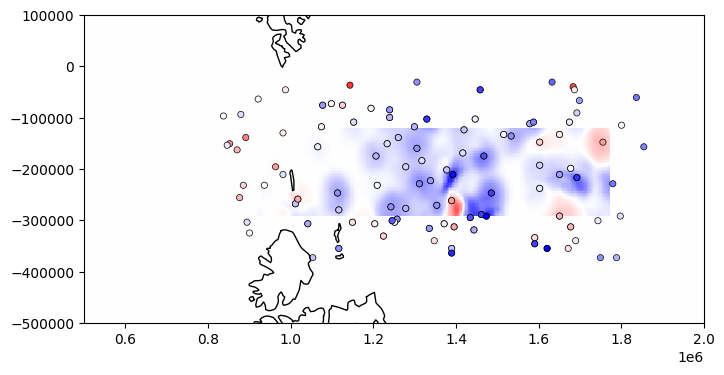

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

c.grid.plot_field(ax, np.mean(state_post, axis=0) - np.mean(state_prior, axis=0), vmin=-0.5, vmax=0.5, cmap='bwr')

c.grid.plot_land(ax, showgrid=False)

vmin = -0.5
vmax = 0.5
cmap = [plt.cm.bwr(x) for x in np.linspace(0, 1, 40)]

for p in range(320, 325):
    obs_ind = obs_list[p]
    out = obs[obs_ind] - np.mean(obs_prior[:, obs_ind], axis=0)
    cind = np.maximum(np.minimum(np.round((out-vmin)/(vmax-vmin)*40), 40-1), 0).astype(int)
    ax.scatter(obs_x[obs_ind], obs_y[obs_ind], s=20, color=np.array(cmap)[cind, 0:3], edgecolor='k', linewidth=0.5)

ax.set_xlim(0.5e6, 2e6)
ax.set_ylim(-0.5e6, 0.1e6)